This covers data handling, datasets, loader and tranforms in PyG.

In [1]:
print("Hello! Welcome!! Bye!!!")

Hello! Welcome!! Bye!!!


# Data Handling 

In PyG a graph G is an instance of torch_geometric.data.Data, and has following attributes:

- G.x: Node feature matrix with shape [num_nodes, num_node_features]
- G.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long
- G.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
- G.y: Target to train against, has arbitary shape depending on the task, eg: node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
- G.pos: Node position matrix with shape [num_nodes, num_dimensions]

None of these attributes are required, and the torch_geometric.data.Data is not restricted with these attributes alone.

Both torchvision, and Pytorch use tuple of an image and a target, which is ommited by PyG to allow for various data structures in clean and understandable way.

In [10]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


## NOTES
1. Do .contiguous after doing transpose operation
2. The torch_geometric.data.Data takes unidirectional edges.
3. The elements in edge_index of shape [2, num_edges] should only hold indices in the range {0, ..., num_nodes - 1}, for accessing the node features which is a tensor, zero-indexed.

In [23]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1], [1, 0], [1, 2], [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(edge_index=edge_index.t().contiguous(), x = x)

# validation on the data performed to check whether data obeys the properties required by PyG
data.validate(raise_on_error=True)

True

#### Utility functions of torch_geometric.data.Data

In [26]:
print(data.keys())

print(data['x'])

for key, item in data:
    print(f"{key} found in data")
    
'edge_attr' in data

print(data.num_nodes)

print(data.num_edges)

print(data.num_node_features)

print(data.has_isolated_nodes())

print(data.has_self_loops())

print(data.is_directed())

device = torch.device('cpu')
data = data.to(device)

['x', 'edge_index']
tensor([[-1.],
        [ 0.],
        [ 1.]])
x found in data
edge_index found in data
3
4
1
False
False
False


In [ ]:
# from torch_geometric.datasets import Planetoid

# dataset = Planetoid(root='/tmp/Cora', name='Cora')

## Mini-batches

PyG achieves parallelization over a mini-batch by creating sparse block diagonal adjacency matrices (defined by edge_index) and concatenating feature and target matrices in the node dimension.

This composition allows differing number of nodes and edges over examples in one batch.

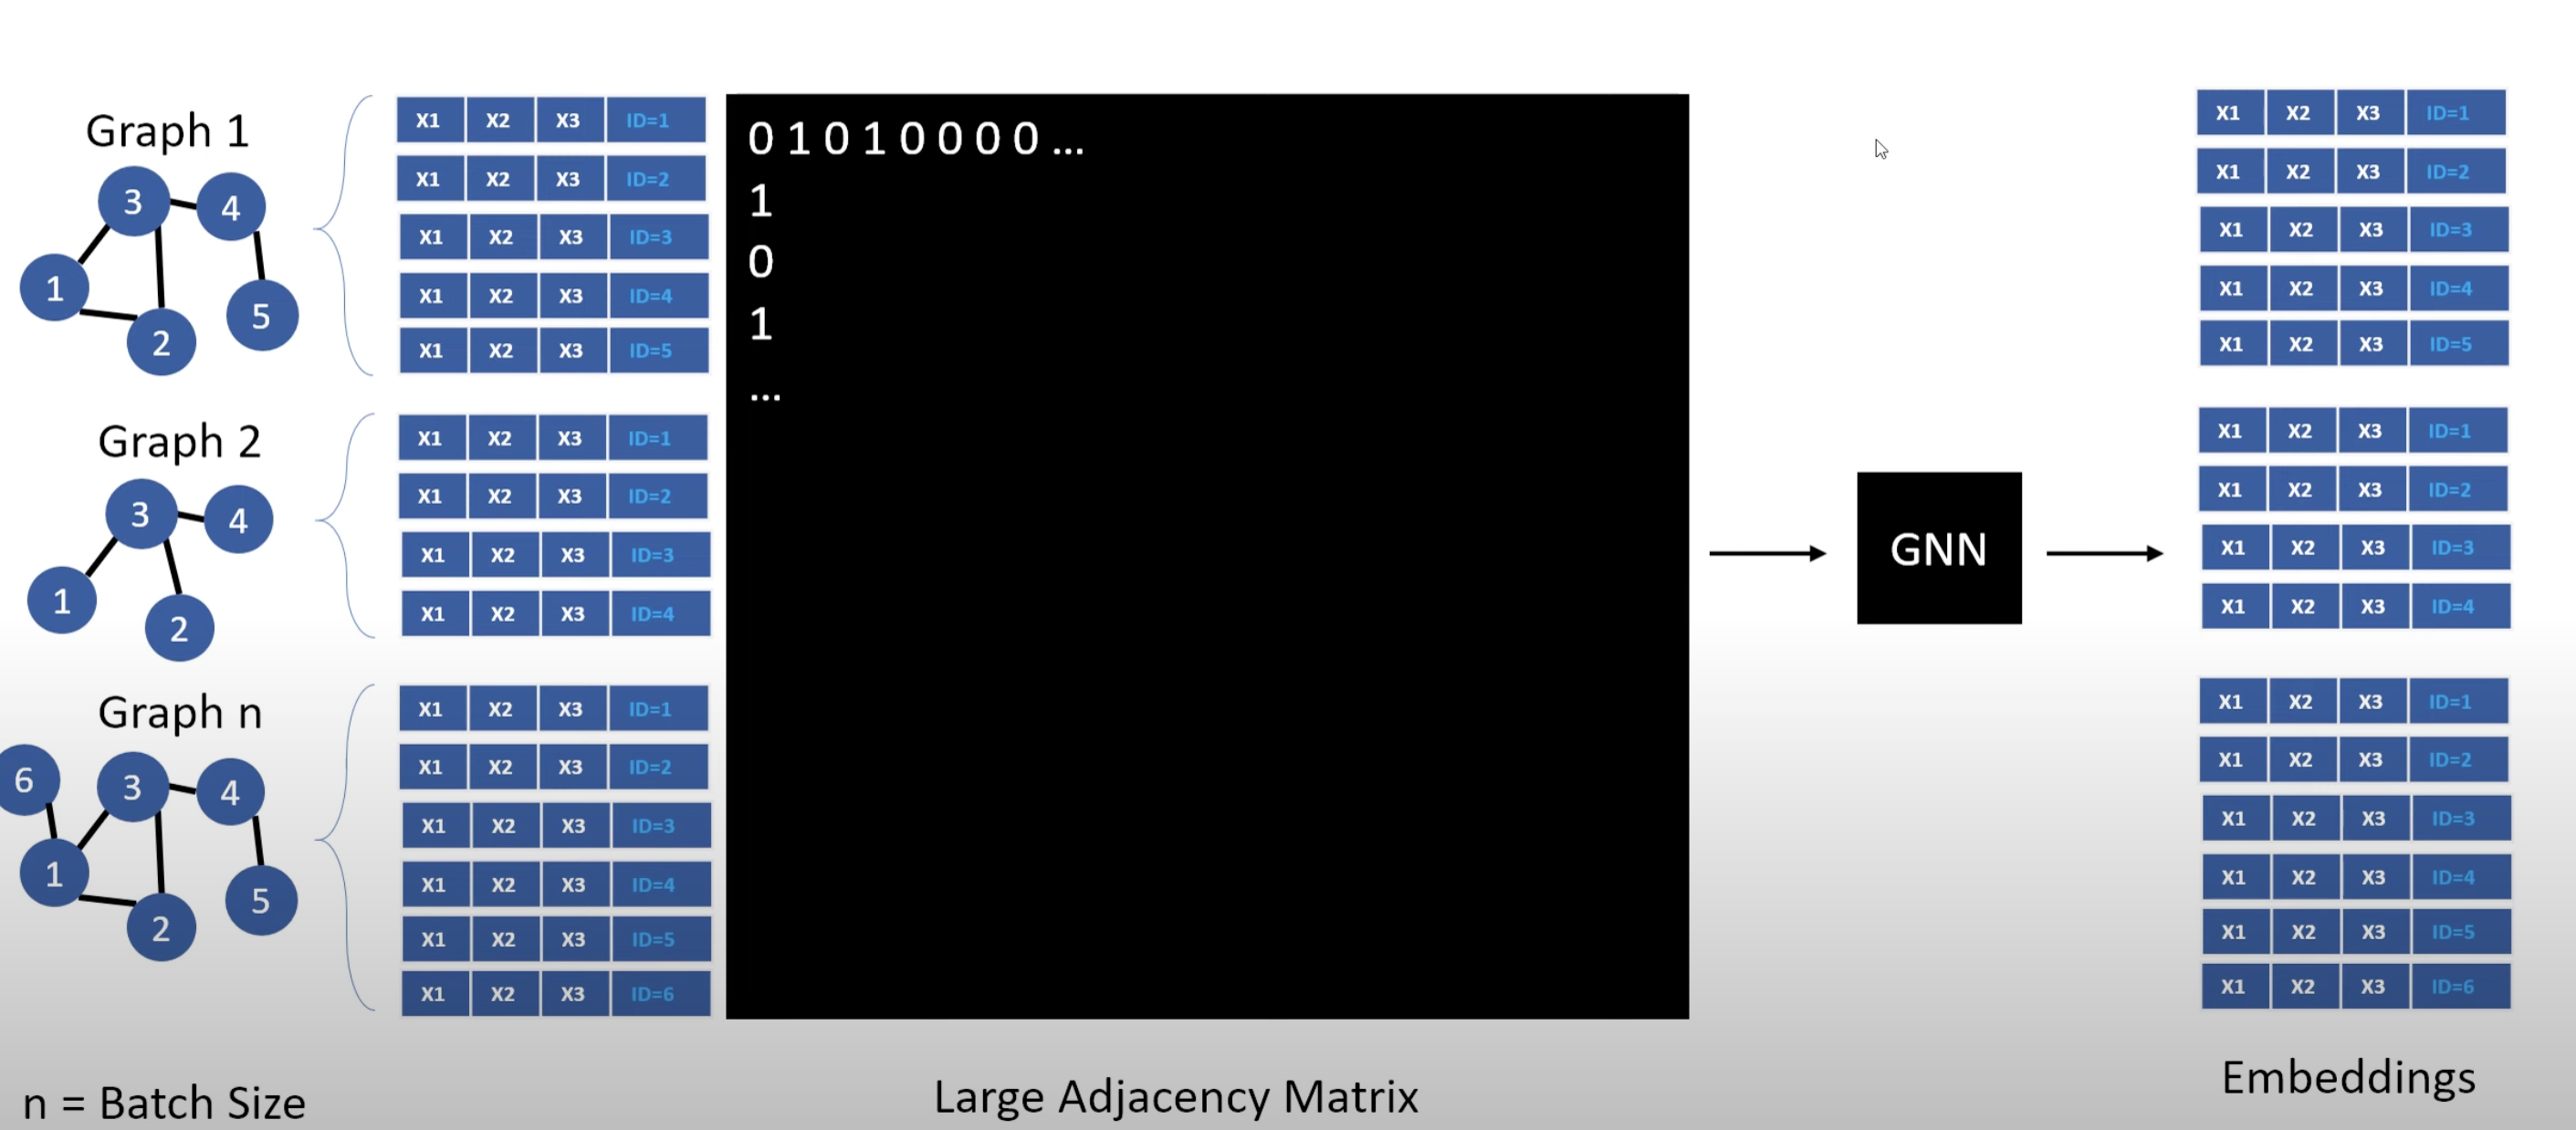

torch_geometric.loader.DataLoader takes care of the concatenation process, torch_geometric.data.Batch inherits from torch_geometric.data.Data and contains an additional attribute batch which maps each node to its respective graph in the batch.

## torch_geometric's scatter and segment functions
Scatter and Segment operations are reduce operations based on a given "group-index" tensor.

segment operations require the "group-index" tensor to be sorted, whereas scatter operations are not subject to these requirements.

Reduces all values from the src tensor to out at the indices specified in the index tensor along the **last dimension of index.**

In [30]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import scatter
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
for data in loader:
    print(data)
    print(data.num_graphs)
    print(data.batch)
    x = scatter(data.x, data.batch, dim=0, reduce='mean')
    print(x.size())
    break

DataBatch(edge_index=[2, 4114], x=[1089, 21], y=[32], batch=[1089], ptr=[33])
32
tensor([ 0,  0,  0,  ..., 31, 31, 31])
torch.Size([32, 21])


## Data Transforms

PyG comes with its own transforms similar to torchvision, which expect a Data object as input and returan a new transformed Data object.

Transforms can be chained together using torch_geometric.transforms.Compose and are applied before saving a processed dataset on disk (pre_transform) or before accessing a graph in a dataset (transform).

In [31]:
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'])
dataset[0]

Extracting /tmp/ShapeNet/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1])

We convert the point cloud dataset into a graph dataset by generating nearest neighbor graphs from the point clouds via transforms

In [32]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
dataset = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'],
                   pre_transform=T.KNNGraph(k=6))
dataset[0]

/Users/subhashp/Documents/Open-Source/transformers/.env/lib/python3.10/site-packages/torch_geometric/data/dataset.py:239: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1])

In [35]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'], 
                   pre_transform=T.KNNGraph(),
                   transform=T.RandomJitter(0.01))
dataset[0]

/Users/subhashp/Documents/Open-Source/transformers/.env/lib/python3.10/site-packages/torch_geometric/data/dataset.py:239: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1])